In [220]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [149]:
df = pd.read_csv('day.csv')

In [150]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [151]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

# Data Cleaning

In [152]:
## Dropping unusable columns

df.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)

In [153]:
## Mapping category codes to names for easier analysis

seasons_mapping={1:'spring',2:'summer',3:'fall',4:'winter'}

weather_mapping={1:'clear',2:'cloudy',3:'rain_snow',4:'heavy_rain_snow'}

df['season_name'] = df.season.map(seasons_mapping)

df['weather'] = df.weathersit.map(weather_mapping)

In [154]:
# Data types all seem to be correct
df.dtypes

season           int64
yr               int64
mnth             int64
holiday          int64
weekday          int64
workingday       int64
weathersit       int64
temp           float64
atemp          float64
hum            float64
windspeed      float64
cnt              int64
season_name     object
weather         object
dtype: object

In [155]:
# No NA values
df.isna().any()

season         False
yr             False
mnth           False
holiday        False
weekday        False
workingday     False
weathersit     False
temp           False
atemp          False
hum            False
windspeed      False
cnt            False
season_name    False
weather        False
dtype: bool

In [156]:
## Creating dummy variables for use in the model

dummy_df = pd.get_dummies(df[['season_name','weather']],drop_first=True)

df = pd.concat([df,dummy_df],axis=1)

# Univatriate analysis : understanding the distribution of independent and target variables

In [159]:
percentiles=[.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]

In [160]:
## There do not seem to be any major outliers in the numerical columns - no outlier treatment required
## What we are looking for is large jumps in value towards the higher percentile values

df[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].describe(percentiles=percentiles).style.format('{:,.0f}')

,temp,atemp,hum,windspeed,cnt
count,730,730,730,730,730
mean,20,24,63,13,"4,508"
std,8,8,14,5,"1,936"
min,2,4,0,2,22
1%,6,7,31,4,689
5%,9,11,41,5,"1,330"
10%,11,13,45,7,"1,743"
20%,13,16,50,8,"2,654"
30%,15,18,54,10,"3,517"
40%,18,21,59,11,"4,091"


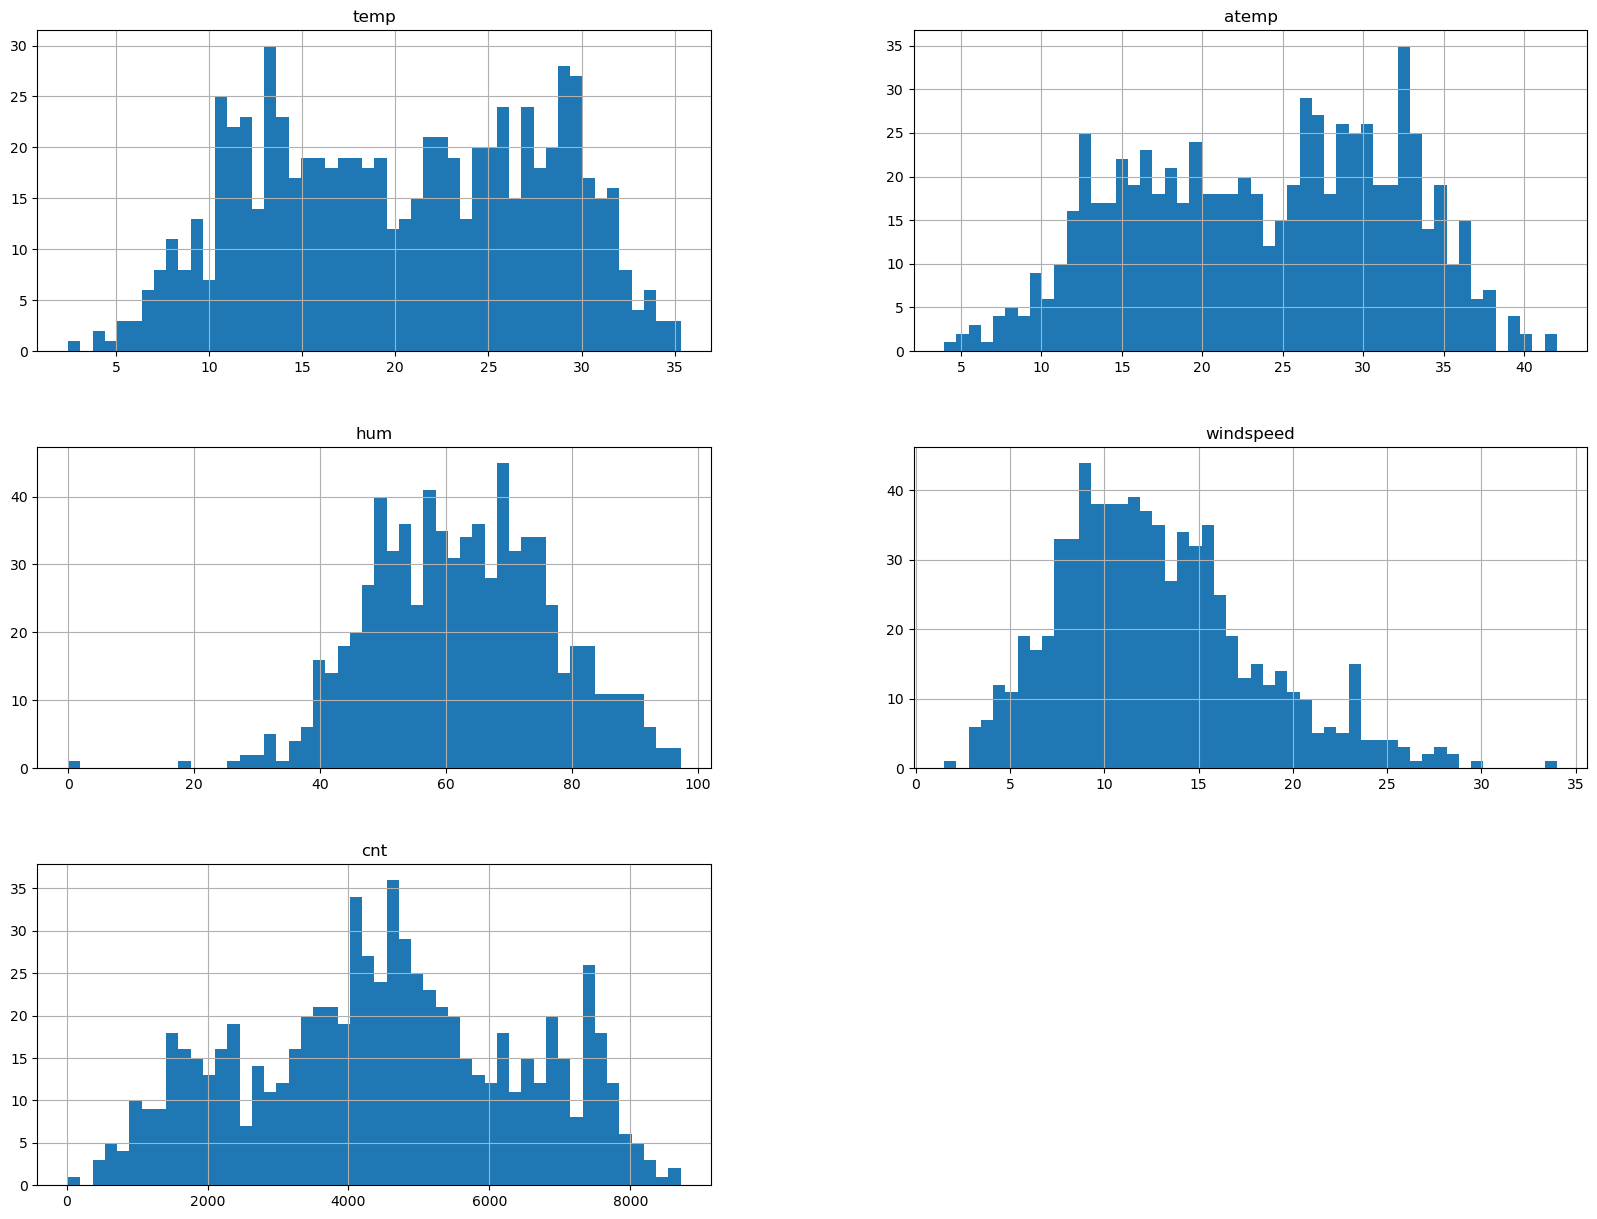

In [161]:
## Distributions of humidity and windspeed seem like slightly skewed normal distributions
## temp and atemp are flatter, somewhat bimodal (not very clear though, but there seems to be a dip around 20 for temp and 25 for atemp)
## cnt is somewhat normal, but has several spikes and dips at specific values

df[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].hist(bins=50, figsize=(20,15))
plt.show()

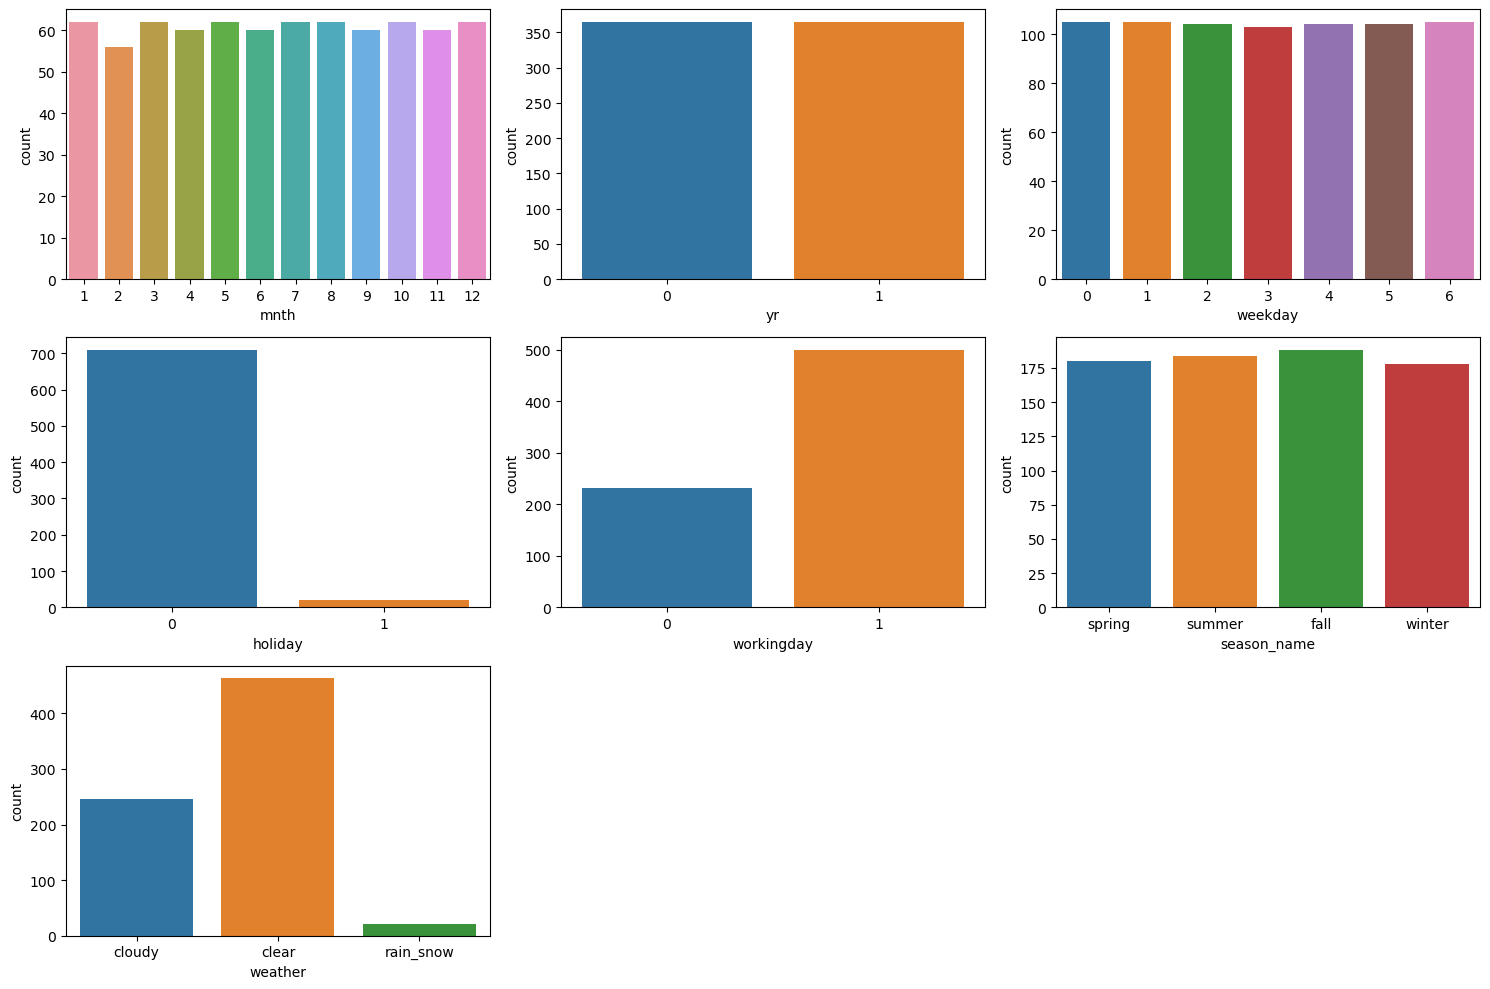

In [162]:
## Data distribution across months, years and days of week and seasons is very even
## Holidays are very few, as expected
## Mostly clear or cloudy weather, very few examples of rain and snow

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10)) 

axs = axs.flatten()

cols = ['mnth', 'yr', 'weekday','holiday',  'workingday','season_name','weather']

for i, col in enumerate(cols):
    sns.countplot(x=col, data=df, ax=axs[i])

fig.delaxes(axs[-1]) 
fig.delaxes(axs[-2])

plt.tight_layout()
plt.show()

In [163]:
# Checking actual (normalized) value counts for the less evenly distributed columns
df.holiday.value_counts(normalize=True)

0    0.971233
1    0.028767
Name: holiday, dtype: float64

In [164]:
df.weather.value_counts(normalize=True)

clear        0.634247
cloudy       0.336986
rain_snow    0.028767
Name: weather, dtype: float64

In [165]:
df[df.workingday==1].weekday.unique()

array([1, 2, 3, 4, 5])

In [166]:
## Creating separate column weekend to distinguish between midweek holidays and regular weekends

df['weekend'] = np.where(df.weekday.isin([0,6]),1,0)

In [167]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'season_name',
       'weather', 'season_name_spring', 'season_name_summer',
       'season_name_winter', 'weather_cloudy', 'weather_rain_snow', 'weekend'],
      dtype='object')

# Bivariate analysis : looking into the relationship between independent and target variables

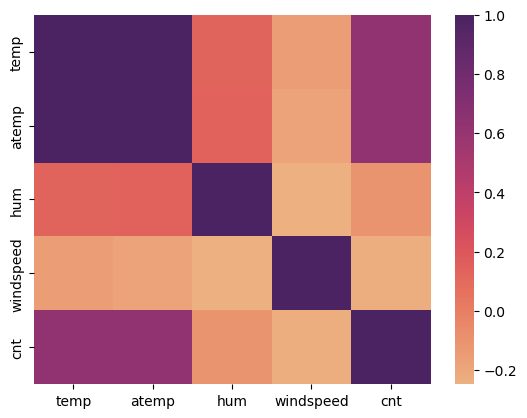

In [168]:
## temp and atemp are almost perfectly correlated
## Intuitively we may drop one of the columns - but there might be useful information contained in diff b/w the columns

corrs = df[['temp', 'atemp', 'hum', 'windspeed','cnt']].corr()
sns.heatmap(corrs,cmap='flare')
plt.show()

In [169]:
corrs

,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.991696,0.128565,-0.158186,0.627044
atemp,0.991696,1.000000,0.141512,-0.183876,0.630685
hum,0.128565,0.141512,1.000000,-0.248506,-0.098543
windspeed,-0.158186,-0.183876,-0.248506,1.000000,-0.235132
cnt,0.627044,0.630685,-0.098543,-0.235132,1.000000


In [170]:
# Capturing the diff b/w atemp and temp as a separate variable
df['tempdiff'] = (df['atemp']-df['temp'])

In [171]:
## Temmpdiff has some massive outliers in the lower percentiles
df.tempdiff.describe(percentiles=[0.001,.005,.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99])

count    730.000000
mean       3.407062
std        1.195945
min      -17.536653
0.1%      -4.857846
0.5%       0.454258
1%         0.873198
5%         1.702607
10%        2.119162
20%        2.783439
30%        3.186603
40%        3.453087
50%        3.659499
60%        3.782882
70%        3.874365
80%        4.029159
90%        4.286965
95%        4.614853
99%        5.376346
max        7.903550
Name: tempdiff, dtype: float64

In [172]:
## Capping at 0.1% percentile
cap = np.percentile(df.tempdiff,.1)
df.loc[df.tempdiff<cap,'tempdiff']=cap

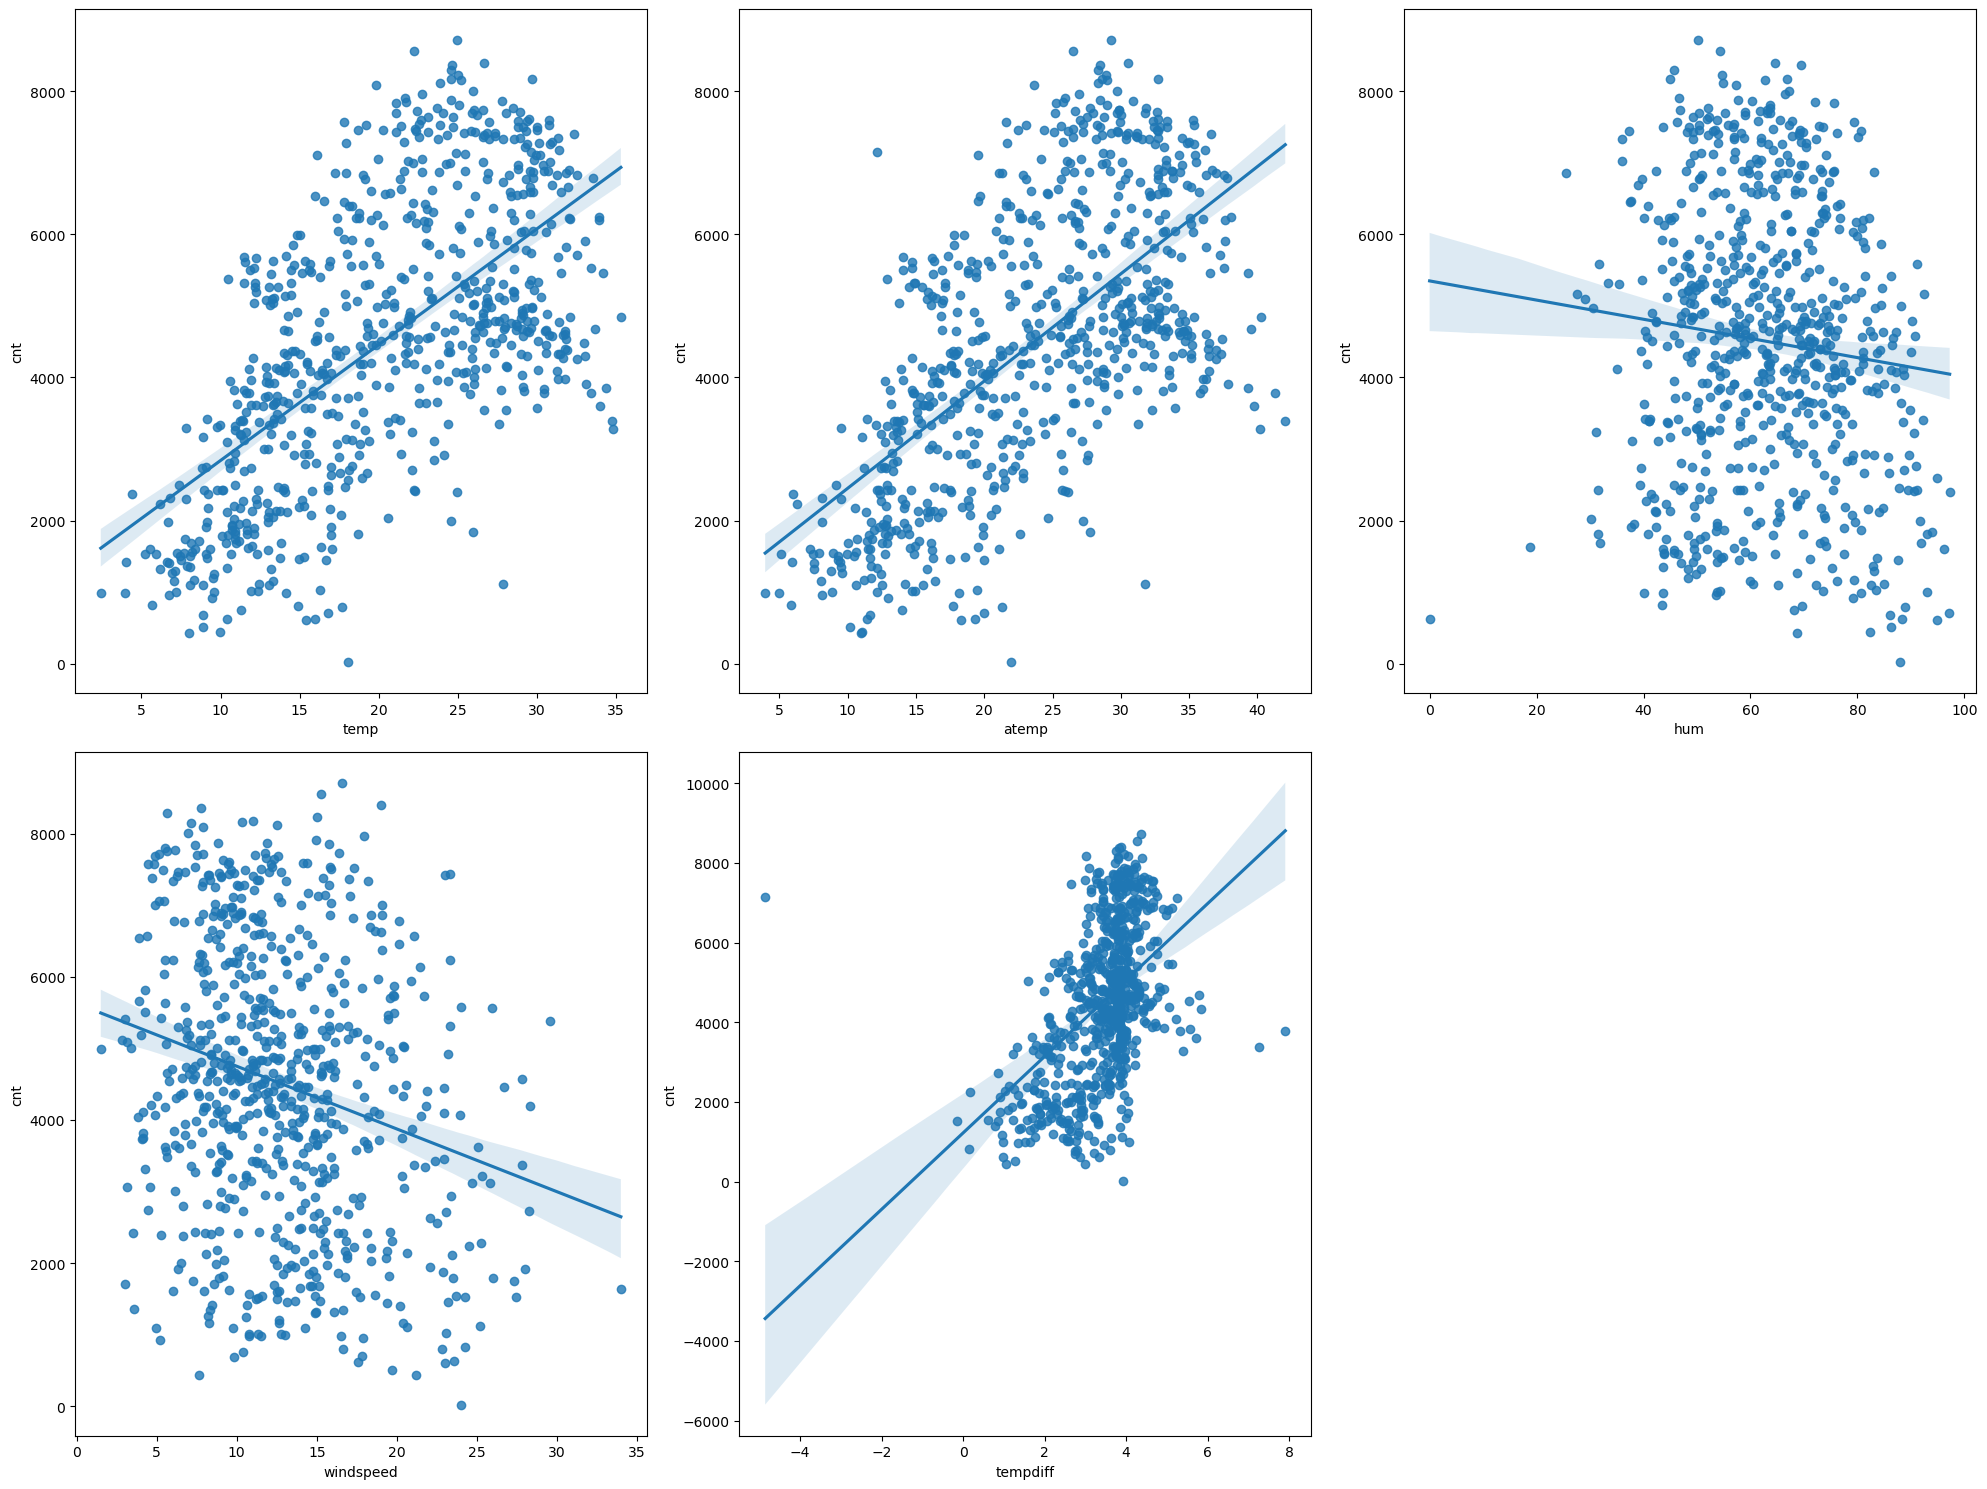

In [173]:
## temp/atemp seem to have a strong linear relationship with rentals
## Tempdiff also seems to have a linear relationship, but not as strong
## With humidity and windspeed the relationship is not so clear

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))  

axs = axs.flatten()

independent_vars = ['temp', 'atemp', 'hum', 'windspeed','tempdiff']
target_var = 'cnt'

for i, col in enumerate(independent_vars):
    sns.regplot(x=col, y=target_var, data=df, ax=axs[i])

fig.delaxes(axs[-1]) 
plt.tight_layout()
plt.show()

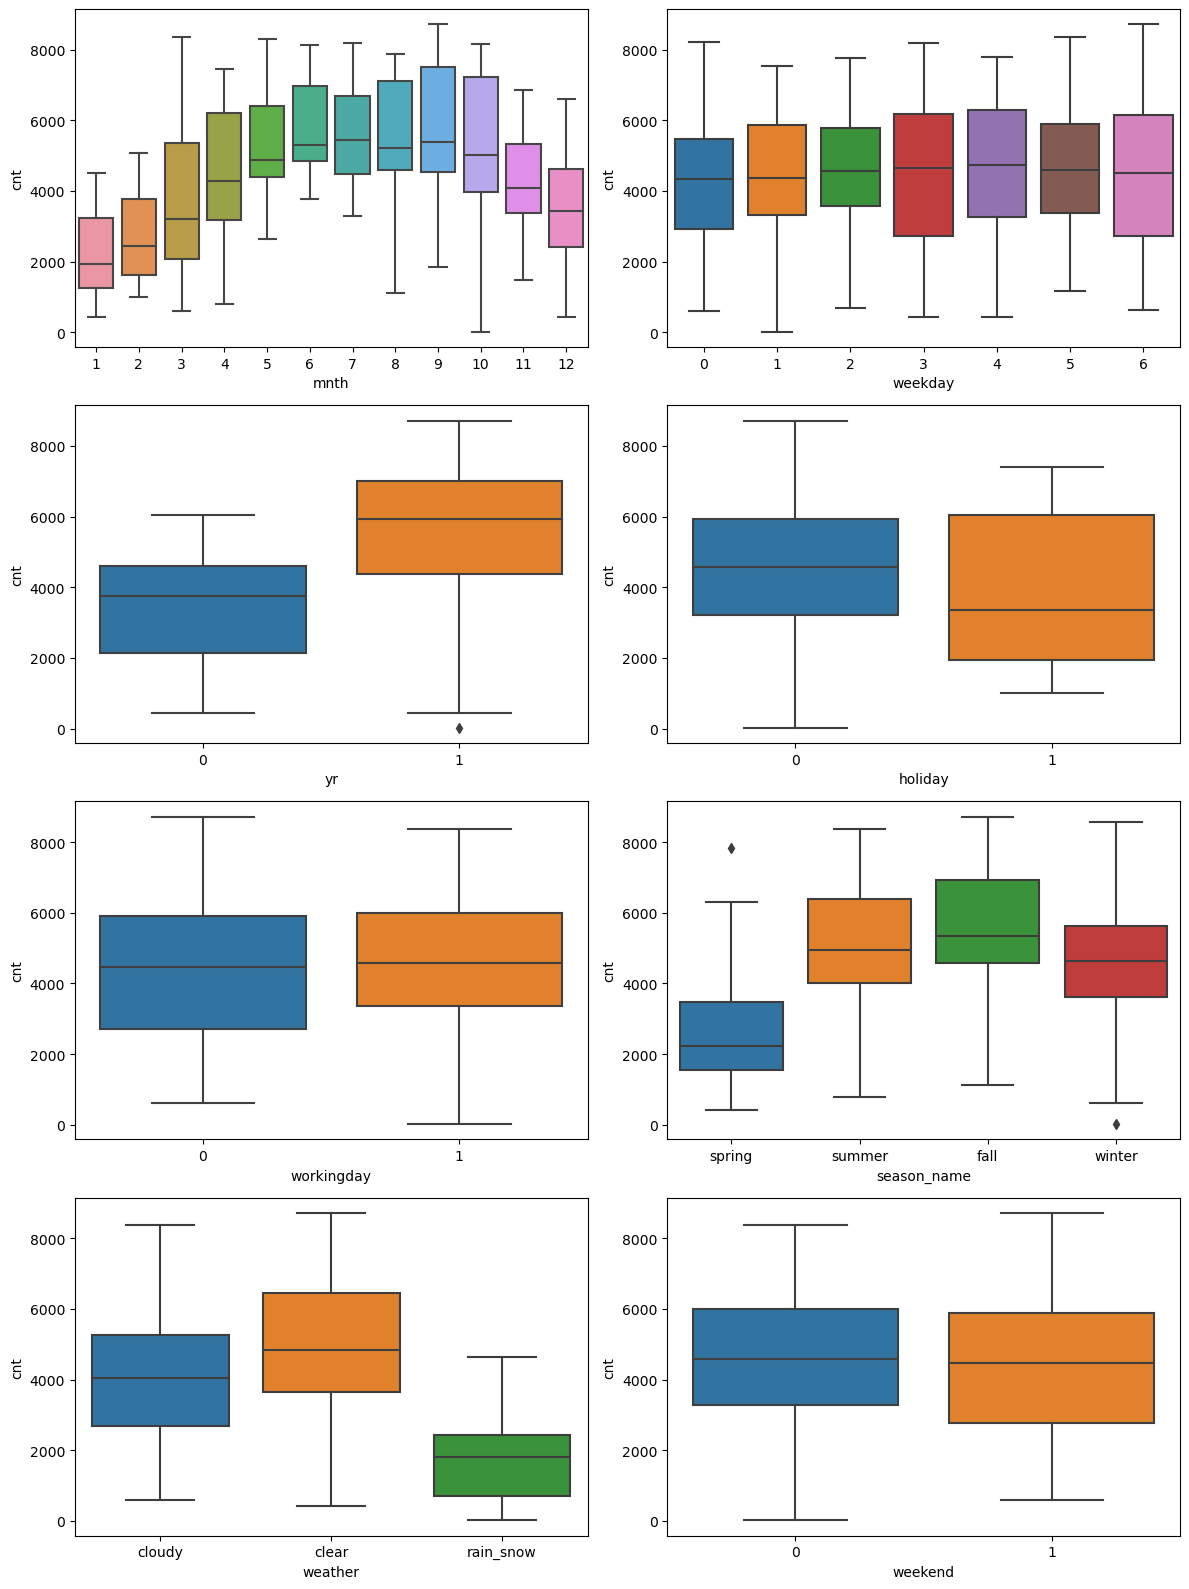

In [174]:
## There is a clear growth in rentals from first to second year
## Holidays seem to have lower rentals, but weekends have no little to no effect
## Summer and fall have most rentals, followed by winter - spring has lowest rentals by far
## Low spring demand could also be due to demand growing over time (spring being the first few months of each both years)
## Day of week has no effect
## Rentals are also highest when there is clear weather, followed by cloudy - rain/snow has low rentals

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))  

axs = axs.flatten()

independent_vars = ['mnth','weekday', 'yr', 'holiday',  'workingday','season_name','weather','weekend']
target_var = 'cnt'

for i, col in enumerate(independent_vars):
    sns.boxplot(x=col, y=target_var, data=df, ax=axs[i])


plt.tight_layout()
plt.show()

In [186]:
# Seasons will capture the seasonality across months in a given year
# In order to capture the linear trend component, we can combine year with month

df['month_num'] = (df.yr*12)+df.mnth


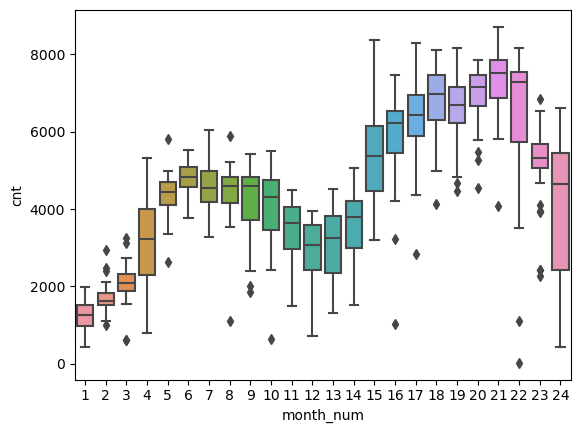

In [262]:
## there is some effect of seasonality as well as growth over time

sns.boxplot(x='month_num', y='cnt', data=df)
plt.show()

# Train- test split

In [187]:
## Dropping weekday as they contain no useful information that is not already captured by workingday,holiday and weekend
## Dropping month as we are using yr & month_num to capture linear trend, and seasons to capture yearly seasonality


final_vars = [ 'yr', 'month_num', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_name_spring',  'weekend',
              'season_name_summer', 'season_name_winter', 'weather_cloudy', 'weather_rain_snow','tempdiff']

In [193]:
X = df[final_vars]
y = df['cnt']

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [273]:
## Checking dimensions to ensure correct split

print('X train and test :\n')
print(X_train.shape)
print(X_test.shape)
print('\ny train and test :\n')
print(y_train.shape)
print(y_test.shape)

X train and test :

(511, 14)
(219, 14)

y train and test :

(511,)
(219,)


# Feature Scaling

In [195]:
# Scaling the numeric columns in order to ensure effect size of variables are comparable

min_max_scaler = MinMaxScaler()

In [198]:
numeric_vars = ['month_num',  'temp', 'hum', 'windspeed','tempdiff']

In [200]:
X_train[numeric_vars] = min_max_scaler.fit_transform(X_train[numeric_vars])

In [213]:
X_test[numeric_vars] = min_max_scaler.transform(X_test[numeric_vars])

In [271]:
## Ensuring dimensions are correct post tranformation

print(X_train.shape)
print(X_test.shape)

(511, 14)
(219, 14)


# Feature selection - Hybrid Approach  : RFE followed by manual analysis of p-values and VIF

## Select top 10 features using RFE

In [205]:
model = LinearRegression()

In [206]:
rfe = RFE(estimator=model, n_features_to_select=10, step=1)

In [207]:
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=10)

In [208]:
top_features = X_train.columns[rfe.support_]

In [210]:
print(top_features)

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'season_name_spring',
       'season_name_winter', 'weather_cloudy', 'weather_rain_snow',
       'tempdiff'],
      dtype='object')


In [215]:
X_train_subset = X_train[top_features]
X_test_subset = X_test[top_features]

# Model building

In [212]:
## Using statsmodel as it gives useful summary statistics like p-value that we will use for our feature selection

In [216]:
## Adding a constant term as statsmodel does not add intercept by default
X_train_subset = sm.add_constant(X_train_subset)
X_test_subset = sm.add_constant(X_test_subset)

In [275]:
## Ensuring dimensions are correct post adding constant (should be 10+1)

print(X_train_subset.shape)
print(X_test_subset.shape)

(511, 11)
(219, 11)


In [217]:
## Fit the model
lin_model = sm.OLS(y_train, X_train_subset)
results = lin_model.fit()

In [219]:
## Overall R-squared and adj. R-squared values seem good
## F-statistic is low, hence model fit is good
## p-value of tempdiff is high, so we might need to remove that

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     234.7
Date:                Tue, 11 Jul 2023   Prob (F-statistic):          1.12e-181
Time:                        16:43:49   Log-Likelihood:                -4152.2
No. Observations:                 511   AIC:                             8326.
Df Residuals:                     500   BIC:                             8373.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2448.6102    449.043      5.453      0.000    1566.366    3330.855
yr                  2019.2062     74.266     27.189      0.000    1873.295    2165.117
holiday             -742.9358    234.233     -3.172      0.002   -1203.139    -282.733
temp                3650.4011    289.522     12.608      0.000    3081.572    4219.230
hum                -1179.7052    343.363     -3.436      0.001   -1854.318    -505.092
windspeed          -1392.0525    239.060     -5.823      0.000   -1861.738    -922.367
season_name_spring -1017.4252    135.461     -7.511      0.000   -1283.568    -751.282
season_name_winter   447.2565    113.486      3.941      0.000     224.289     670.224
weather_cloudy      -457.4473     96.245     -4.753      0.000    -646.541    -268.354
weather_rain_snow  -2092.7085    242.823     -8.618      0.000   -2569.787   -1615.630
tempdiff             938.9812    618.197      1.519      0.129    -275.603    2153.565
==============================================================================
Omnibus:                       70.734   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.871
Skew:                          -0.707   Prob(JB):                     2.38e-39
Kurtosis:                       5.521   Cond. No.                         33.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [227]:
## VIF for all variables seems low, no need to remove any variables

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_subset.columns
vif_data["vif"] = [variance_inflation_factor(X_train_subset, i) for i in range(len(X_train_subset.columns))]

vif_data

,feature,vif
0,const,150.727270
1,yr,1.030378
2,holiday,1.016818
3,temp,3.183887
4,hum,1.868256
5,windspeed,1.226955
6,season_name_spring,2.520774
7,season_name_winter,1.797998
8,weather_cloudy,1.563448
9,weather_rain_snow,1.255813


In [228]:
## Dropping tempdiff due to high p-value

X_train_final = X_train_subset.drop('tempdiff',axis=1)
X_test_final = X_test_subset.drop('tempdiff',axis=1)

In [234]:
lin_model_final = sm.OLS(y_train, X_train_final)
results = lin_model_final.fit()

In [235]:
## Now all p-values are low so all co-efficients are significant
## Negligible changes in R-squared, Adj. R-squared, AIC and BIC
## In terms of effect size -
## temp has the largest effect on rentals, followed by rain/snow and year number
## This indicates that high temperatures will coincide with more rentals, and generally growth can be expected from year 0 to 1
## Rainy weather or snow has a large negative effect on rentals
## Windspeed, humidity also have a moderate negative effect on rentals
## The spring season also coincides with reduced demand
## Holidays and cloudy weather also have a small negative effect, while winter season sees a small increase in rentals

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     259.8
Date:                Tue, 11 Jul 2023   Prob (F-statistic):          2.13e-182
Time:                        20:37:49   Log-Likelihood:                -4153.4
No. Observations:                 511   AIC:                             8327.
Df Residuals:                     501   BIC:                             8369.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2979.3220    282.425     10.549      0.000    2424.438    3534.206
yr                  2021.3978     74.348     27.188      0.000    1875.325    2167.471
holiday             -767.5502    233.977     -3.280      0.001   -1227.247    -307.854
temp                3840.2722    261.485     14.686      0.000    3326.530    4354.015
hum                -1125.1961    341.928     -3.291      0.001   -1796.986    -453.407
windspeed          -1474.8545    233.064     -6.328      0.000   -1932.759   -1016.950
season_name_spring -1022.1582    135.602     -7.538      0.000   -1288.576    -755.740
season_name_winter   468.1810    112.793      4.151      0.000     246.575     689.787
weather_cloudy      -468.0231     96.118     -4.869      0.000    -656.866    -279.180
weather_rain_snow  -2141.7833    240.977     -8.888      0.000   -2615.234   -1668.333
==============================================================================
Omnibus:                       64.284   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.755
Skew:                          -0.646   Prob(JB):                     1.24e-35
Kurtosis:                       5.425   Cond. No.                         18.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Residual analysis

In [241]:
y_train_pred =  results.predict(X_train_final)

In [242]:
res = y_train - y_train_pred

Mean :  0


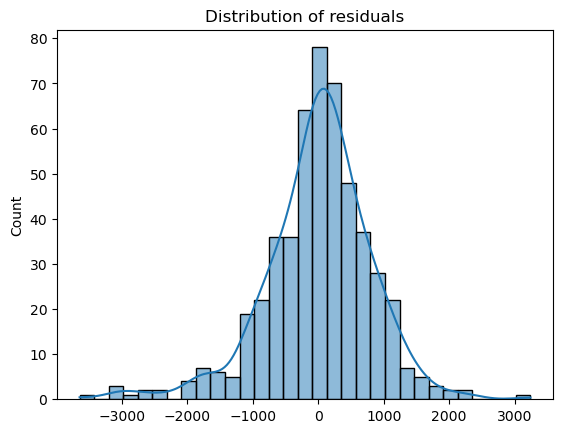

In [257]:
## Residuals are normally distributed with mean ~0

print('Mean : ',round(res.mean()))
plt.title('Distribution of residuals')
sns.histplot(x=res,kde=True)
plt.show()

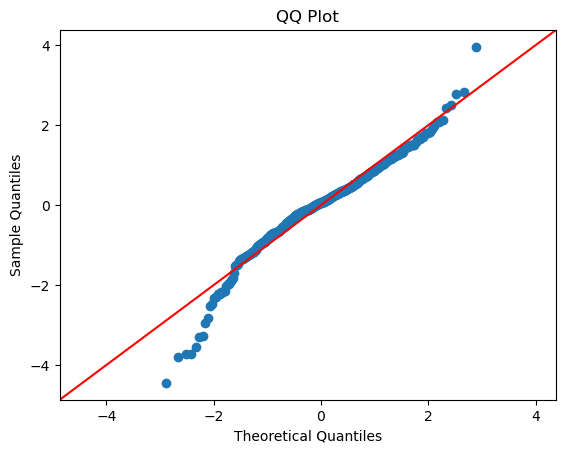

In [263]:
## Q-Q plot of residuals is a more rigorous test for normality - points should lie on 45 degree line
## Lower quantiles have some points that fall outside the line but most points are on the line

fig = sm.qqplot(res, fit=True, line='45')
plt.title('QQ Plot')
plt.show()

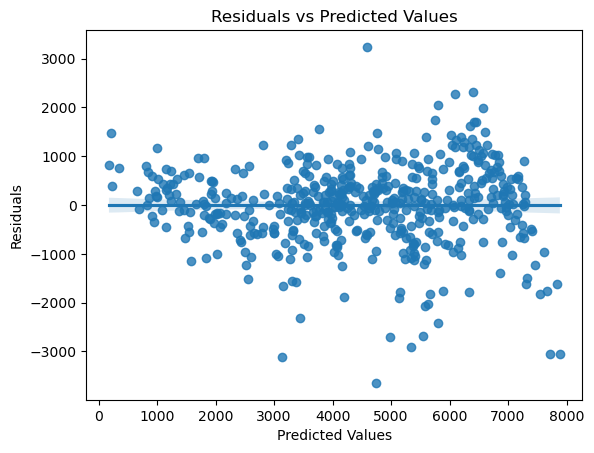

In [258]:
## No identifyable pattern in the residuals plotted vs predicted values
## Variance also seems to be roughly constant (homoscedasticity assumption holds true)

plt.title('Residuals vs Predicted Values')
sns.regplot(x=y_train_pred, y=res)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Test set performance

In [259]:
y_pred = results.predict(X_test_final)

In [260]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8076241537218806

In [261]:
## This is very close to the train set (0.824), so this is acceptable and the model has not overfit